# Multiple Linear Regression (Forecasting)

## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import yfinance as yf

## Importing the dataset

In [2]:
from datetime import datetime

ticker = ['RS']
start_date = '2000-01-01'
end_date = datetime.now().date()
df = yf.download(ticker, start=start_date,end=end_date)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,11.71875,11.71875,11.18750,11.21875,7.810857,48600
2000-01-04,11.15625,11.15625,10.37500,10.46875,7.288682,132400
2000-01-05,10.50000,10.75000,10.46875,10.59375,7.375712,29800
2000-01-06,10.68750,10.93750,10.68750,10.93750,7.615039,50600
2000-01-07,11.00000,11.25000,10.96875,11.25000,7.832612,30200


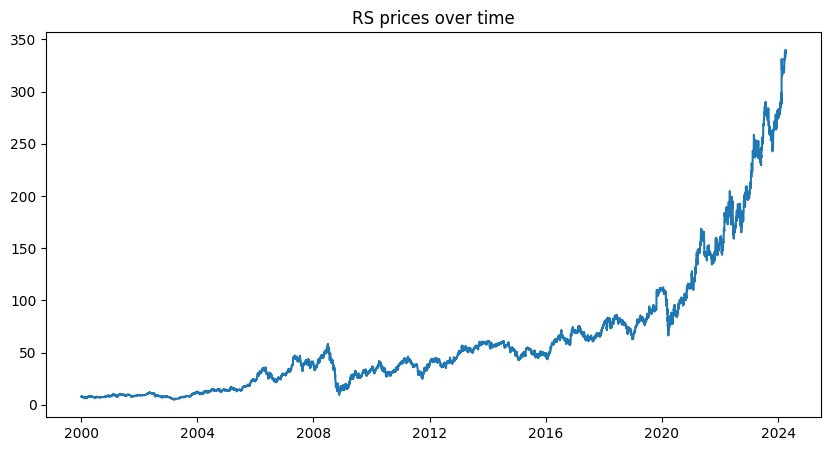

In [3]:
plt.figure(figsize=(10,5))

plt.title('RS prices over time')
plt.plot(df['Adj Close'])
plt.show()

## Upward Trend - Seasonality

<Figure size 640x480 with 0 Axes>

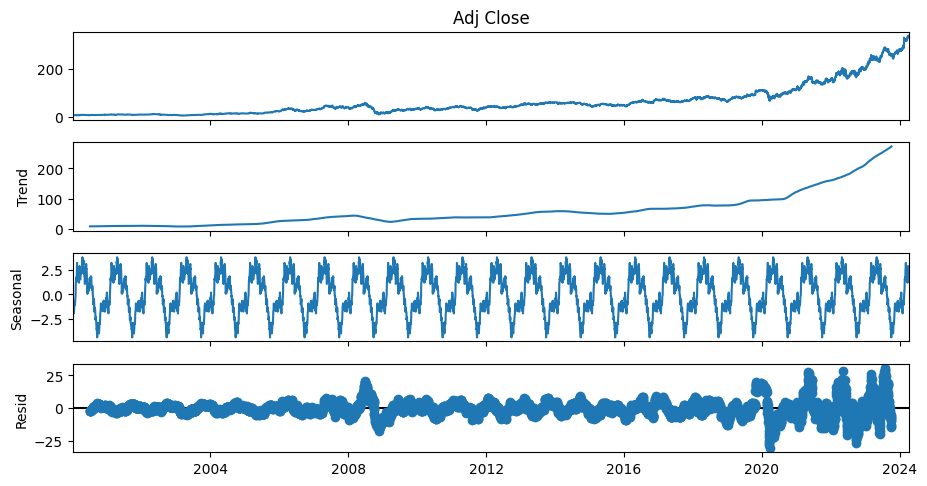

In [4]:
#!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Adj Close'], model='additive', period=252)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10,5)

Notice how the HLOCV values of a certain day corresponds with an Adj Close price. However, you want to predict the $t+1$ Adj Close Price. Therefore, we need to shift our Adj Close price by $t+1$.

Notice how there exists a trend and seasonality in the time series data. We need to capture both.

In [5]:
df['Future Adj Close'] = df['Adj Close']
df = df.drop(columns=['Adj Close'], axis=1)
df.head()

,Open,High,Low,Close,Volume,Future Adj Close
Date,,,,,,
2000-01-03,11.71875,11.71875,11.18750,11.21875,48600,7.810857
2000-01-04,11.15625,11.15625,10.37500,10.46875,132400,7.288682
2000-01-05,10.50000,10.75000,10.46875,10.59375,29800,7.375712
2000-01-06,10.68750,10.93750,10.68750,10.93750,50600,7.615039
2000-01-07,11.00000,11.25000,10.96875,11.25000,30200,7.832612


If the Adj Close column is the same as the close, we dont need to shift periods, but if there is a variation you may need to shift up or down. keep track of that for every stock

In [6]:
X = df.iloc[:,:5]
y = df.iloc[:,-1]
y

Date
2000-01-03      7.810857
2000-01-04      7.288682
2000-01-05      7.375712
2000-01-06      7.615039
2000-01-07      7.832612
                 ...    
2024-04-02    333.079987
2024-04-03    338.510010
2024-04-04    336.279999
2024-04-05    340.040009
2024-04-08    337.079987
Name: Future Adj Close, Length: 6104, dtype: float64

# Check our Assumptions:

- A linear relationship between the dependent and independent variables
- The independent variables are not highly correlated with each other
- The variance of the residuals is constant
- Independence of observation
- Multivariate normality

There are several ways but here is one implementation

## Create the Model

In [7]:
import statsmodels.api as sm
X_constant = sm.add_constant(X)
model = sm.OLS(y,X_constant).fit()

In [8]:
model.params

const    -6.857911
Open     -0.103215
High      0.604538
Low      -0.407732
Close     0.902140
Volume   -0.000003
dtype: float64

In [9]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Future Adj Close   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 4.207e+05
Date:                Tue, 09 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:25:57   Log-Likelihood:                -16179.
No. Observations:                6104   AIC:                         3.237e+04
Df Residuals:                    6098   BIC:                         3.241e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8579      0.087    -78.524      0.000      -7.029      -6.687
Open          -0.1032      0.063     -1.639      0.101      -0.227       0.020
High           0.6045      0.072      8.346      0.000       0.463       0.747
Low           -0.4077      0.068     -5.989      0.000      -0.541      -0.274
Close          0.9021      0.064     14.081      0.000       0.777       1.028
Volume     -3.367e-06   9.58e-08    -35.132      0.000   -3.55e-06   -3.18e-06
==============================================================================
Omnibus:                       12.499   Durbin-Watson:                   0.119
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               10.700
Skew:                          -0.038   Prob(JB):                      0.00475
Kurtosis:                       2.810   Cond. No.                     1.97e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
residuals = model.resid
y_pred = model.predict()

In [11]:
all(residuals == y.values - y_pred)

True

In [12]:
all(y_pred == model.predict(X_constant))

True

## Stationarity

It means properties of my residuals to be constant throught time. One way to check that is Unit Route Test. Adfuller Test

In hypothesis testing, it is very important to choose your significance value. So for example we choose cutoff = 0.05, that means I want to 95% confident to conclude that the series is stationary 

In [13]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(X, cutoff=0.05):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print("p-value = " + str(pvalue) + " The series is likely stationary.")
        return True
    #That means if the p-value < the cutoff, I reject my null hypothesis, that there is no Route Unit Test,which concludes that the series
    # is likely stationary
    else:
        print("p-value = " + str(pvalue) + " The series is likely stationary.")
        return False

In [14]:
check_stationarity(residuals)

p-value = 0.035388933107730294 The series is likely stationary.


True

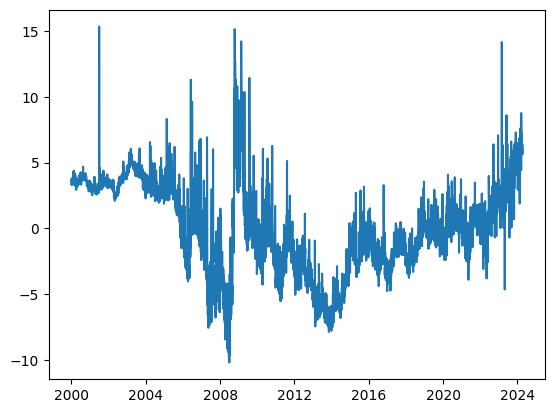

In [15]:
plt.plot(residuals)

Obtaining such $R^2$ and $Adj. R^2$ values indicates spurious regression. This is a common phenomena in time series where you might think that your model has performed well due to these metric results but they fail in testing sets on the long run. It is important to check if the residual values are stationary. If the p-value is less than your significance level (ours is 5%), we reject the null hypothesis that the residuals have a unit root (stationary). You can read more about spurious regression [here](http://www.fsb.miamioh.edu/lij14/672_2014_s8.pdf).

NOTE: The residuals of this model might change as you change the timespan of the data.

## Homoscedasticity

Homoscedasticity is to see if there some trend when I plot my Residuals Vs Actual predicted Values.

In [16]:
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

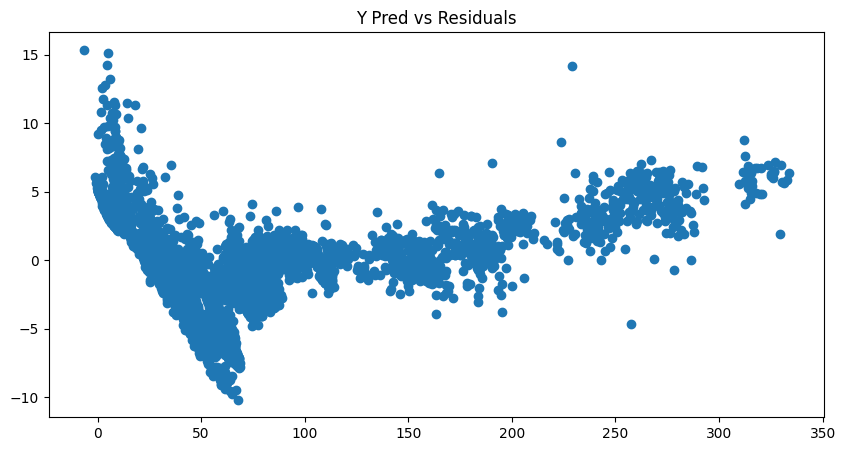

In [17]:
plt.figure(figsize=(10,5))
plt.scatter(y_pred, residuals)
plt.title('Y Pred vs Residuals')
plt.show()

As seen from the above graph, there seems to be a linear trend between the two variables and thus we cannot conclude that our features are Homoscedastic. There needs to be no relationship between the two.

## Multivariate Normality


<Axes: ylabel='Density'>

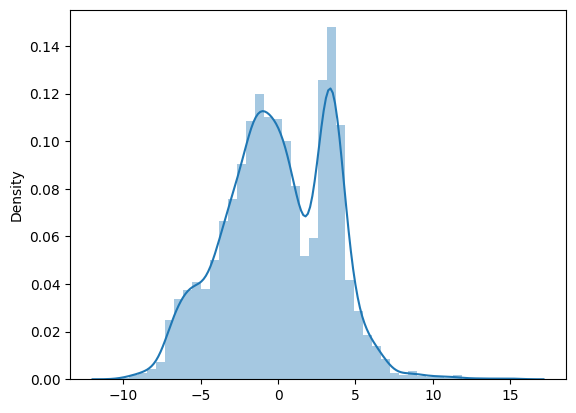

In [18]:
sns.distplot(residuals)

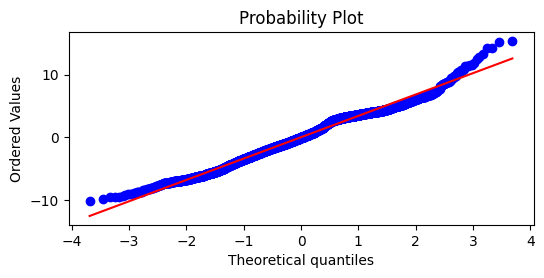

In [19]:
import scipy

fig, ax = plt.subplots(figsize=(6,2.5))
_, (_, _, r) = scipy.stats.probplot(residuals, plot=ax, fit=True)

In [20]:
np.mean(residuals)

-1.5384228040310426e-13

As seen from our histogram, our data does not follow a normal distribution. In addition, the PP Plot shows that more than half the data points fall on the line which implies multivariate normality. However, there exists heavy tails towards the ends of the plot. Furthermore, the residual mean should be zero centered. My personal judgement would go with "we can do better than this as this data cannot be assumed to be approximately normal". 

Use your best judgement or do more tests!

## Independence of Observations

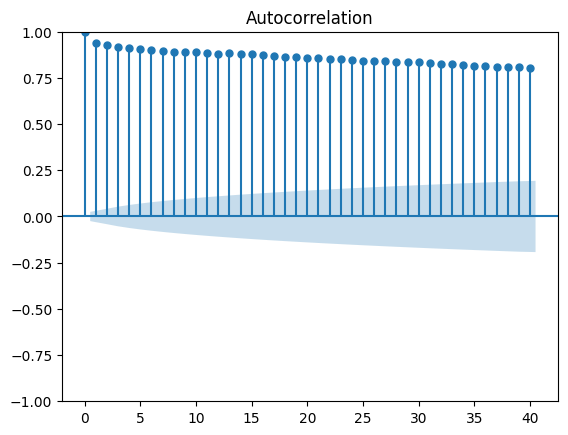

In [21]:
import statsmodels.tsa.api as smt

ALPHA  = 0.05
acf = smt.graphics.plot_acf(residuals, lags = 40, alpha=ALPHA)
acf.show()

In [22]:
residuals

Date
2000-01-03    3.398147
2000-01-04    3.785451
2000-01-05    3.630334
2000-01-06    3.624779
2000-01-07    3.449755
                ...   
2024-04-02    6.421563
2024-04-03    5.855427
2024-04-04    5.686723
2024-04-05    6.386562
2024-04-08    5.647953
Length: 6104, dtype: float64

As seen above, the features seem to be highly correlated with one another as the stems escape the highlighted region. Statistically, we say that any stem that escaptes the highlighted region is significant, implying large enough correlation between the time series values and the lagged time series values.

## Lack of Multicollinearity

We will use the variance inflation factor as our test:
    
- values $> 10 \implies$ heavy multicollinearity
- values $< 5 \implies$ little relationship of this feature with other features
- values between $5$ and $10$ $\implies$ use your best judgement

In [23]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif':vif[0:]}, index=X_constant.columns).T

,const,Open,High,Low,Close,Volume
vif,3.961112,8174.327986,11045.658093,9355.026609,8471.707282,1.195919


As seen from the dataframe above, there exists heavy multicollinearity in our dataset (except for our volume feature) but that is not enough.

Since most assumptions fail, we need to change our dataset or create new features. Let us use monthly data instead of daily data.

# Create Monthly Dataset

In [24]:
# df.index = pd.to_datetime(df.index)
# df = df.resample('1M').mean()
# df

df_1 = yf.download(ticker, start = start_date, end = end_date, interval='1mo')
df_1.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-01,276.399994,284.329987,261.769989,279.679993,278.725372,5145000
2024-01-01,278.769989,291.450012,273.880005,285.420013,284.445801,4154400
2024-02-01,286.390015,333.329987,285.140015,321.220001,320.123596,5648400
2024-03-01,322.959991,337.109985,312.829987,334.179993,333.039337,5403400
2024-04-01,335.399994,342.200012,328.829987,337.079987,337.079987,1237500


In [25]:
df_1['Future Adj Close'] = df_1['Adj Close'].shift(periods=-1)
df_1 = df_1.drop(columns=['Adj Close'], axis=1).dropna()

In [26]:
X = df_1.iloc[:,:5]
y = df_1.iloc[:,-1]

### Create a Model

In [27]:
import statsmodels.api as sm

X_constant = sm.add_constant(X)
model = sm.OLS(y,X_constant).fit()

In [28]:
model.params

const    -5.965715e+00
Open     -3.085940e-01
High      7.644166e-01
Low       3.757640e-02
Close     4.990646e-01
Volume   -3.193032e-07
dtype: float64

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Future Adj Close   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4244.
Date:                Tue, 09 Apr 2024   Prob (F-statistic):          3.41e-265
Time:                        22:25:59   Log-Likelihood:                -1004.1
No. Observations:                 291   AIC:                             2020.
Df Residuals:                     285   BIC:                             2042.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9657      0.997     -5.985      0.000      -7.928      -4.004
Open          -0.3086      0.144     -2.145      0.033      -0.592      -0.025
High           0.7644      0.176      4.336      0.000       0.417       1.111
Low            0.0376      0.179      0.210      0.834      -0.314       0.389
Close          0.4991      0.168      2.974      0.003       0.169       0.829
Volume     -3.193e-07   5.86e-08     -5.452      0.000   -4.35e-07   -2.04e-07
==============================================================================
Omnibus:                       57.922   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.044
Skew:                           0.633   Prob(JB):                     1.07e-73
Kurtosis:                       8.110   Cond. No.                     3.29e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.29e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
residuals = model.resid
y_pred = model.predict()

In [31]:
all(residuals == y.values - y_pred) 

True

In [32]:
all(y_pred == model.predict(X_constant))

True

In [33]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(X, cutoff = 0.05):
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value ' + str(pvalue) + ' The series is likely stationary')
        return True
    else:
        print('p-value ' + str(pvalue) + ' The series is Not likely stationary')
        return False

In [34]:
check_stationarity(residuals)

p-value 0.476917790940433 The series is Not likely stationary


False

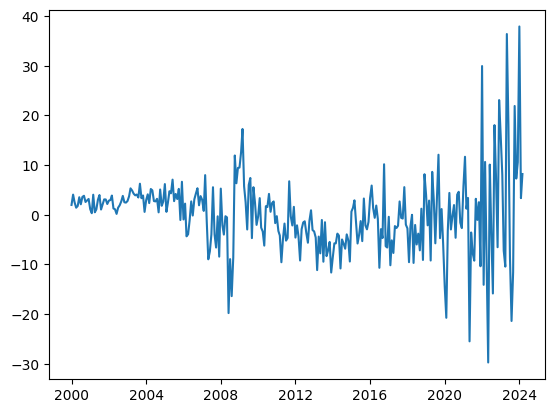

In [35]:
plt.plot(residuals)

### Homoscedasticity

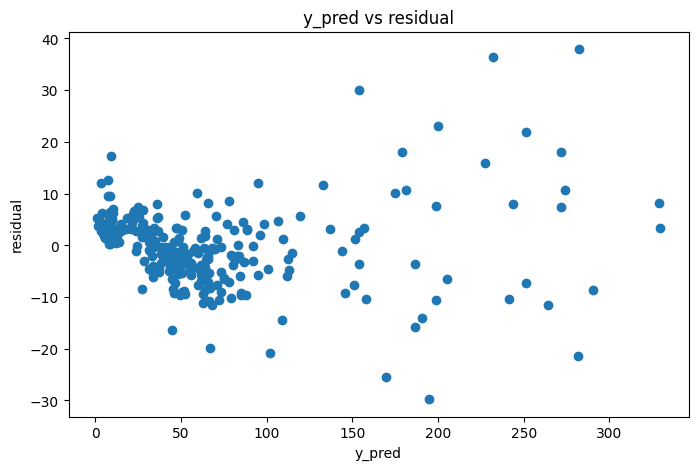

In [36]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals);
plt.title("y_pred vs residual")
plt.xlabel('y_pred')
plt.ylabel("residual")
plt.show()

### Multivariate Normality

<Axes: ylabel='Density'>

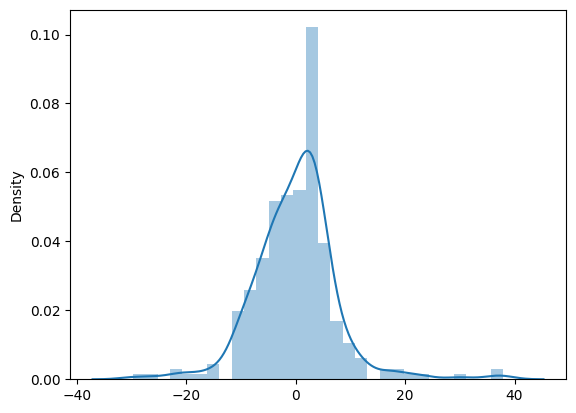

In [37]:
sns.distplot(residuals)

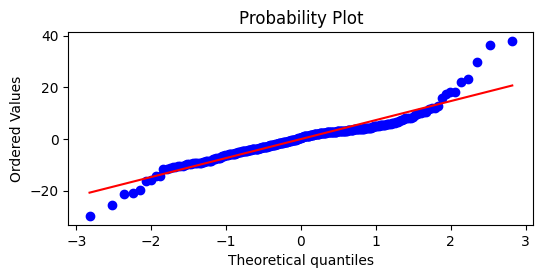

In [38]:
import scipy

fig, ax = plt.subplots(figsize=(6,2.5))
_, (_, _, r) = scipy.stats.probplot(residuals, plot=ax, fit=True)

Heavy tails still exist but we are getting better.

In [39]:
np.mean(residuals)

1.7600200212858334e-09

### Independence of Observations

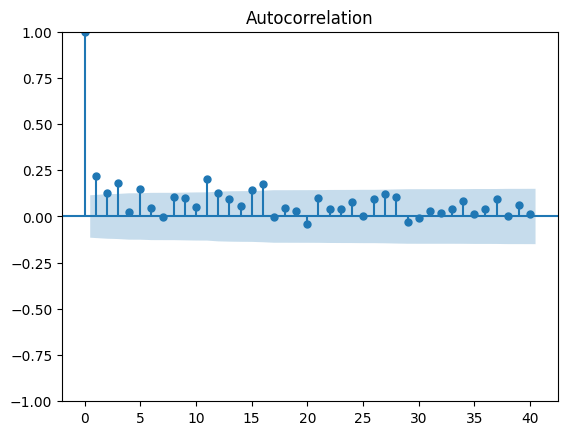

In [40]:
import statsmodels.tsa.api as smt

ALPHA  = 0.05
acf = smt.graphics.plot_acf(residuals, lags = 40, alpha=ALPHA)
acf.show()

### Lack of Multicollinearity

In [41]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif':vif[0:]}, index=X_constant.columns).T

,const,Open,High,Low,Close,Volume
vif,4.870865,390.995685,664.901459,550.238298,560.308793,1.24108


Generally speaking, we are getting better just not there yet. Let us use returns data as they tend to be stationary with time.

# Create Monthly Log-Return Dataset

In [42]:
for col in df_1.columns:
    if col != 'Volume':
        df_1[f'{col}_returns'] = np.log(df_1[col]).diff()

df_1 = df_1.dropna()
df_1.head()

,Open,High,Low,Close,Volume,Future Adj Close,Open_returns,High_returns,Low_returns,Close_returns,Future Adj Close_returns
Date,,,,,,,,,,,
2000-02-01,10.5000,10.8125,8.43750,9.68750,1535800,7.789103,-0.109815,-0.093732,-0.194592,-0.068563,0.143961
2000-03-01,9.6875,11.6875,8.81250,11.18750,1186600,8.030468,-0.080539,0.077817,0.043485,0.143961,0.030517
2000-04-01,11.2500,12.3750,10.96875,11.50000,923000,7.310344,0.149532,0.057158,0.218879,0.027550,-0.093952
2000-05-01,11.4375,12.0000,10.37500,10.46875,1177800,6.693870,0.016529,-0.030772,-0.055651,-0.093952,-0.088098
2000-06-01,10.5000,10.8125,9.31250,9.56250,1172800,7.350132,-0.085522,-0.104204,-0.108041,-0.090545,0.093526


In [43]:
df_1 = df_1.drop(columns = ['Open','High','Low','Close','Future Adj Close','Volume'], axis=1)
df_1.head()

,Open_returns,High_returns,Low_returns,Close_returns,Future Adj Close_returns
Date,,,,,
2000-02-01,-0.109815,-0.093732,-0.194592,-0.068563,0.143961
2000-03-01,-0.080539,0.077817,0.043485,0.143961,0.030517
2000-04-01,0.149532,0.057158,0.218879,0.027550,-0.093952
2000-05-01,0.016529,-0.030772,-0.055651,-0.093952,-0.088098
2000-06-01,-0.085522,-0.104204,-0.108041,-0.090545,0.093526


In [44]:
X = df_1.iloc[:,:4]
y = df_1.iloc[:,-1]

## Check Assumptions

### Create a Model

In [45]:
X_constant = sm.add_constant(X)
model = sm.OLS(y,X_constant).fit()

In [46]:
model.params

const            0.011724
Open_returns    -0.053980
High_returns     0.084429
Low_returns      0.140283
Close_returns   -0.020551
dtype: float64

In [47]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Future Adj Close_returns   R-squared:                       0.026
Model:                                  OLS   Adj. R-squared:                  0.013
Method:                       Least Squares   F-statistic:                     1.938
Date:                      Tue, 09 Apr 2024   Prob (F-statistic):              0.104
Time:                              22:26:01   Log-Likelihood:                 277.37
No. Observations:                       290   AIC:                            -544.7
Df Residuals:                           285   BIC:                            -526.4
Df Model:                                 4                                         
Covariance Type:                  nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0117      0.006      2.099      0.037       0.001       0.023
Open_returns     -0.0540      0.094     -0.576      0.565      -0.238       0.130
High_returns      0.0844      0.126      0.670      0.503      -0.163       0.332
Low_returns       0.1403      0.085      1.646      0.101      -0.028       0.308
Close_returns    -0.0206      0.100     -0.206      0.837      -0.217       0.176
==============================================================================
Omnibus:                       17.859   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.912
Skew:                          -0.251   Prob(JB):                     1.31e-09
Kurtosis:                       4.770   Cond. No.                         30.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
residuals = model.resid
y_pred = model.predict()

In [49]:
all(residuals == y.values - y_pred)

True

all(y_pred == model.predict(X_constant))

In [50]:
check_stationarity(residuals)

p-value 8.654168938874896e-14 The series is likely stationary


True

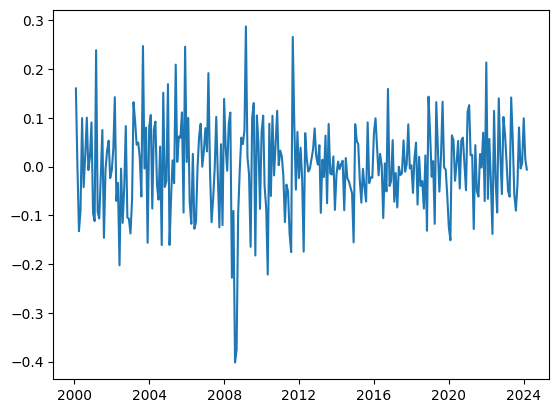

In [51]:
plt.plot(residuals)

### Homoscedasticity

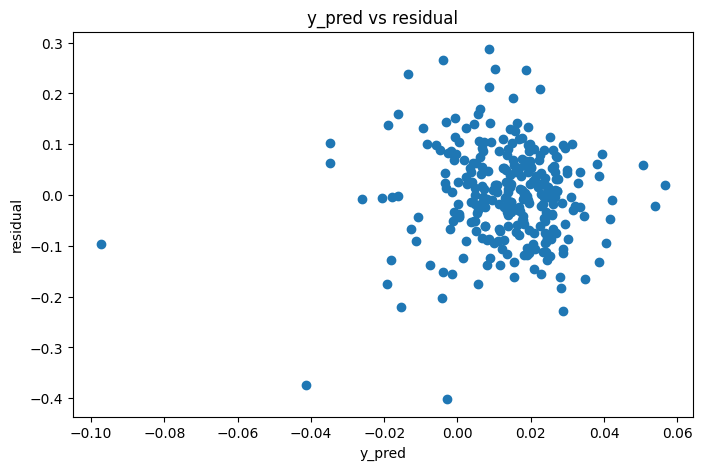

In [52]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals);
plt.title("y_pred vs residual")
plt.xlabel('y_pred')
plt.ylabel("residual")
plt.show()

### Multivariate Normality

<Axes: ylabel='Density'>

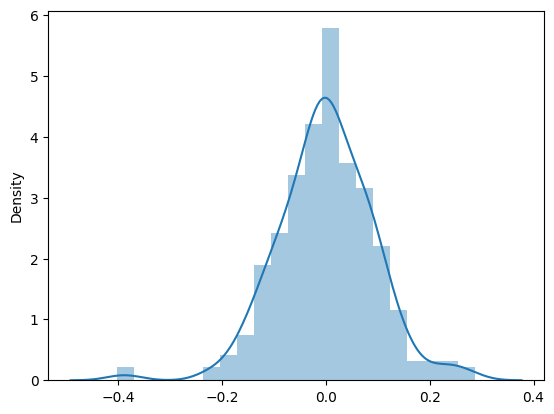

In [53]:
sns.distplot(residuals)

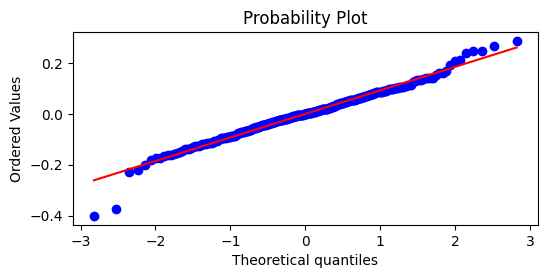

In [54]:
import scipy

fig, ax = plt.subplots(figsize=(6,2.5))
_, (_, _, r) = scipy.stats.probplot(residuals, plot=ax, fit=True)

In [55]:
np.mean(residuals)

-3.4455197315953134e-18

### Independence of Oberservations

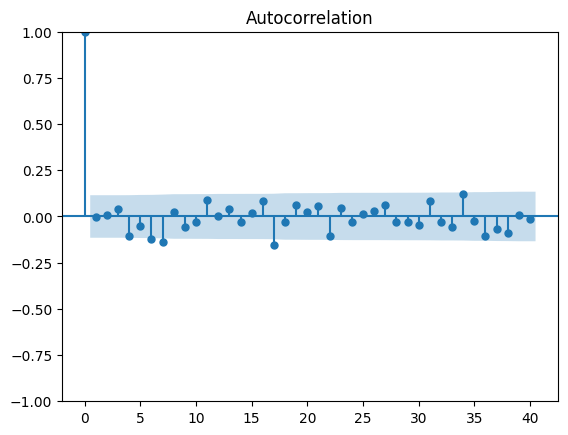

In [56]:
import statsmodels.tsa.api as smt

ALPHA  = 0.05
acf = smt.graphics.plot_acf(residuals, lags = 40, alpha=ALPHA)
acf.show()

### Lack of Multicollinearity

In [57]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_constant.values, i) for i in range(X_constant.shape[1])]
pd.DataFrame({'vif':vif[0:]}, index=X_constant.columns).T

,const,Open_returns,High_returns,Low_returns,Close_returns
vif,1.028362,2.691698,3.147021,2.640688,2.929149


Generally speaking, much better results. If we know the log returns of the open high low close, etc., intuitively speaking, we should be able to predict the log returns of the adjusted close. We cannot use unseen data as training input for our models. We need a different set of features.

IOW, stock prices/returns depends on its previous price. So, there exists autocorrelation and we do not want that.

# Feature Engineering (Technical Analysis)

In [58]:
df_ta = yf.download(ticker, start = start_date, end = end_date, interval = '1mo')
df_ta['Future Adj Close'] = df_ta['Adj Close'].shift(periods=-1)
df_ta.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Future Adj Close
Date,,,,,,,
2000-01-01,11.71875,11.8750,10.25000,10.37500,7.223410,941400,6.744751
2000-02-01,10.50000,10.8125,8.43750,9.68750,6.744751,1535800,7.789103
2000-03-01,9.68750,11.6875,8.81250,11.18750,7.789103,1186600,8.030468
2000-04-01,11.25000,12.3750,10.96875,11.50000,8.030468,923000,7.310344
2000-05-01,11.43750,12.0000,10.37500,10.46875,7.310344,1177800,6.693870


In [59]:
def cmf(high, low, close, volume, n=21, fillna=False):
    ad = (((close - low) - (high - close)) / (high - low)) * volume
    ad = ad.fillna(0)
    cmf = (ad.rolling(n, min_periods=0)).sum() / (volume.rolling(n,min_periods=0)).sum()

    if fillna:
        cmf = cmf.replace([np.inf, -np.inf],np.nan).fillna(0)
    return pd.Series(cmf, name='CMF')

In [60]:
!pip install finta

In [61]:
from finta import TA

indicators = ['RSI','MFI']
dataset = df_ta.copy()

for indicator in indicators:
    ind_data = eval('TA.' + indicator + '(dataset)')
    if not isinstance(ind_data, pd.DataFrame):
        ind_data = ind_data.to_frame()
    dataset = dataset.merge(ind_data, left_index=True, right_index=True)

dataset['CMF'] = cmf(high=dataset.High, low=dataset.Low, close=dataset.Close, volume=dataset.Volume, n=12)
dataset.drop(['High', 'Low', 'Open', 'Close', 'Adj Close','Volume'], axis=1, inplace=True)
dataset.dropna(axis=0, inplace=True)

In [62]:
dataset.head(3)

,Future Adj Close,14 period RSI,14 period MFI,CMF
Date,,,,
2001-02-01,8.246922,63.689896,66.755884,0.097972
2001-03-01,10.327378,54.306865,60.615279,0.015167
2001-04-01,9.640059,68.084537,68.624953,0.104250


## Visualization

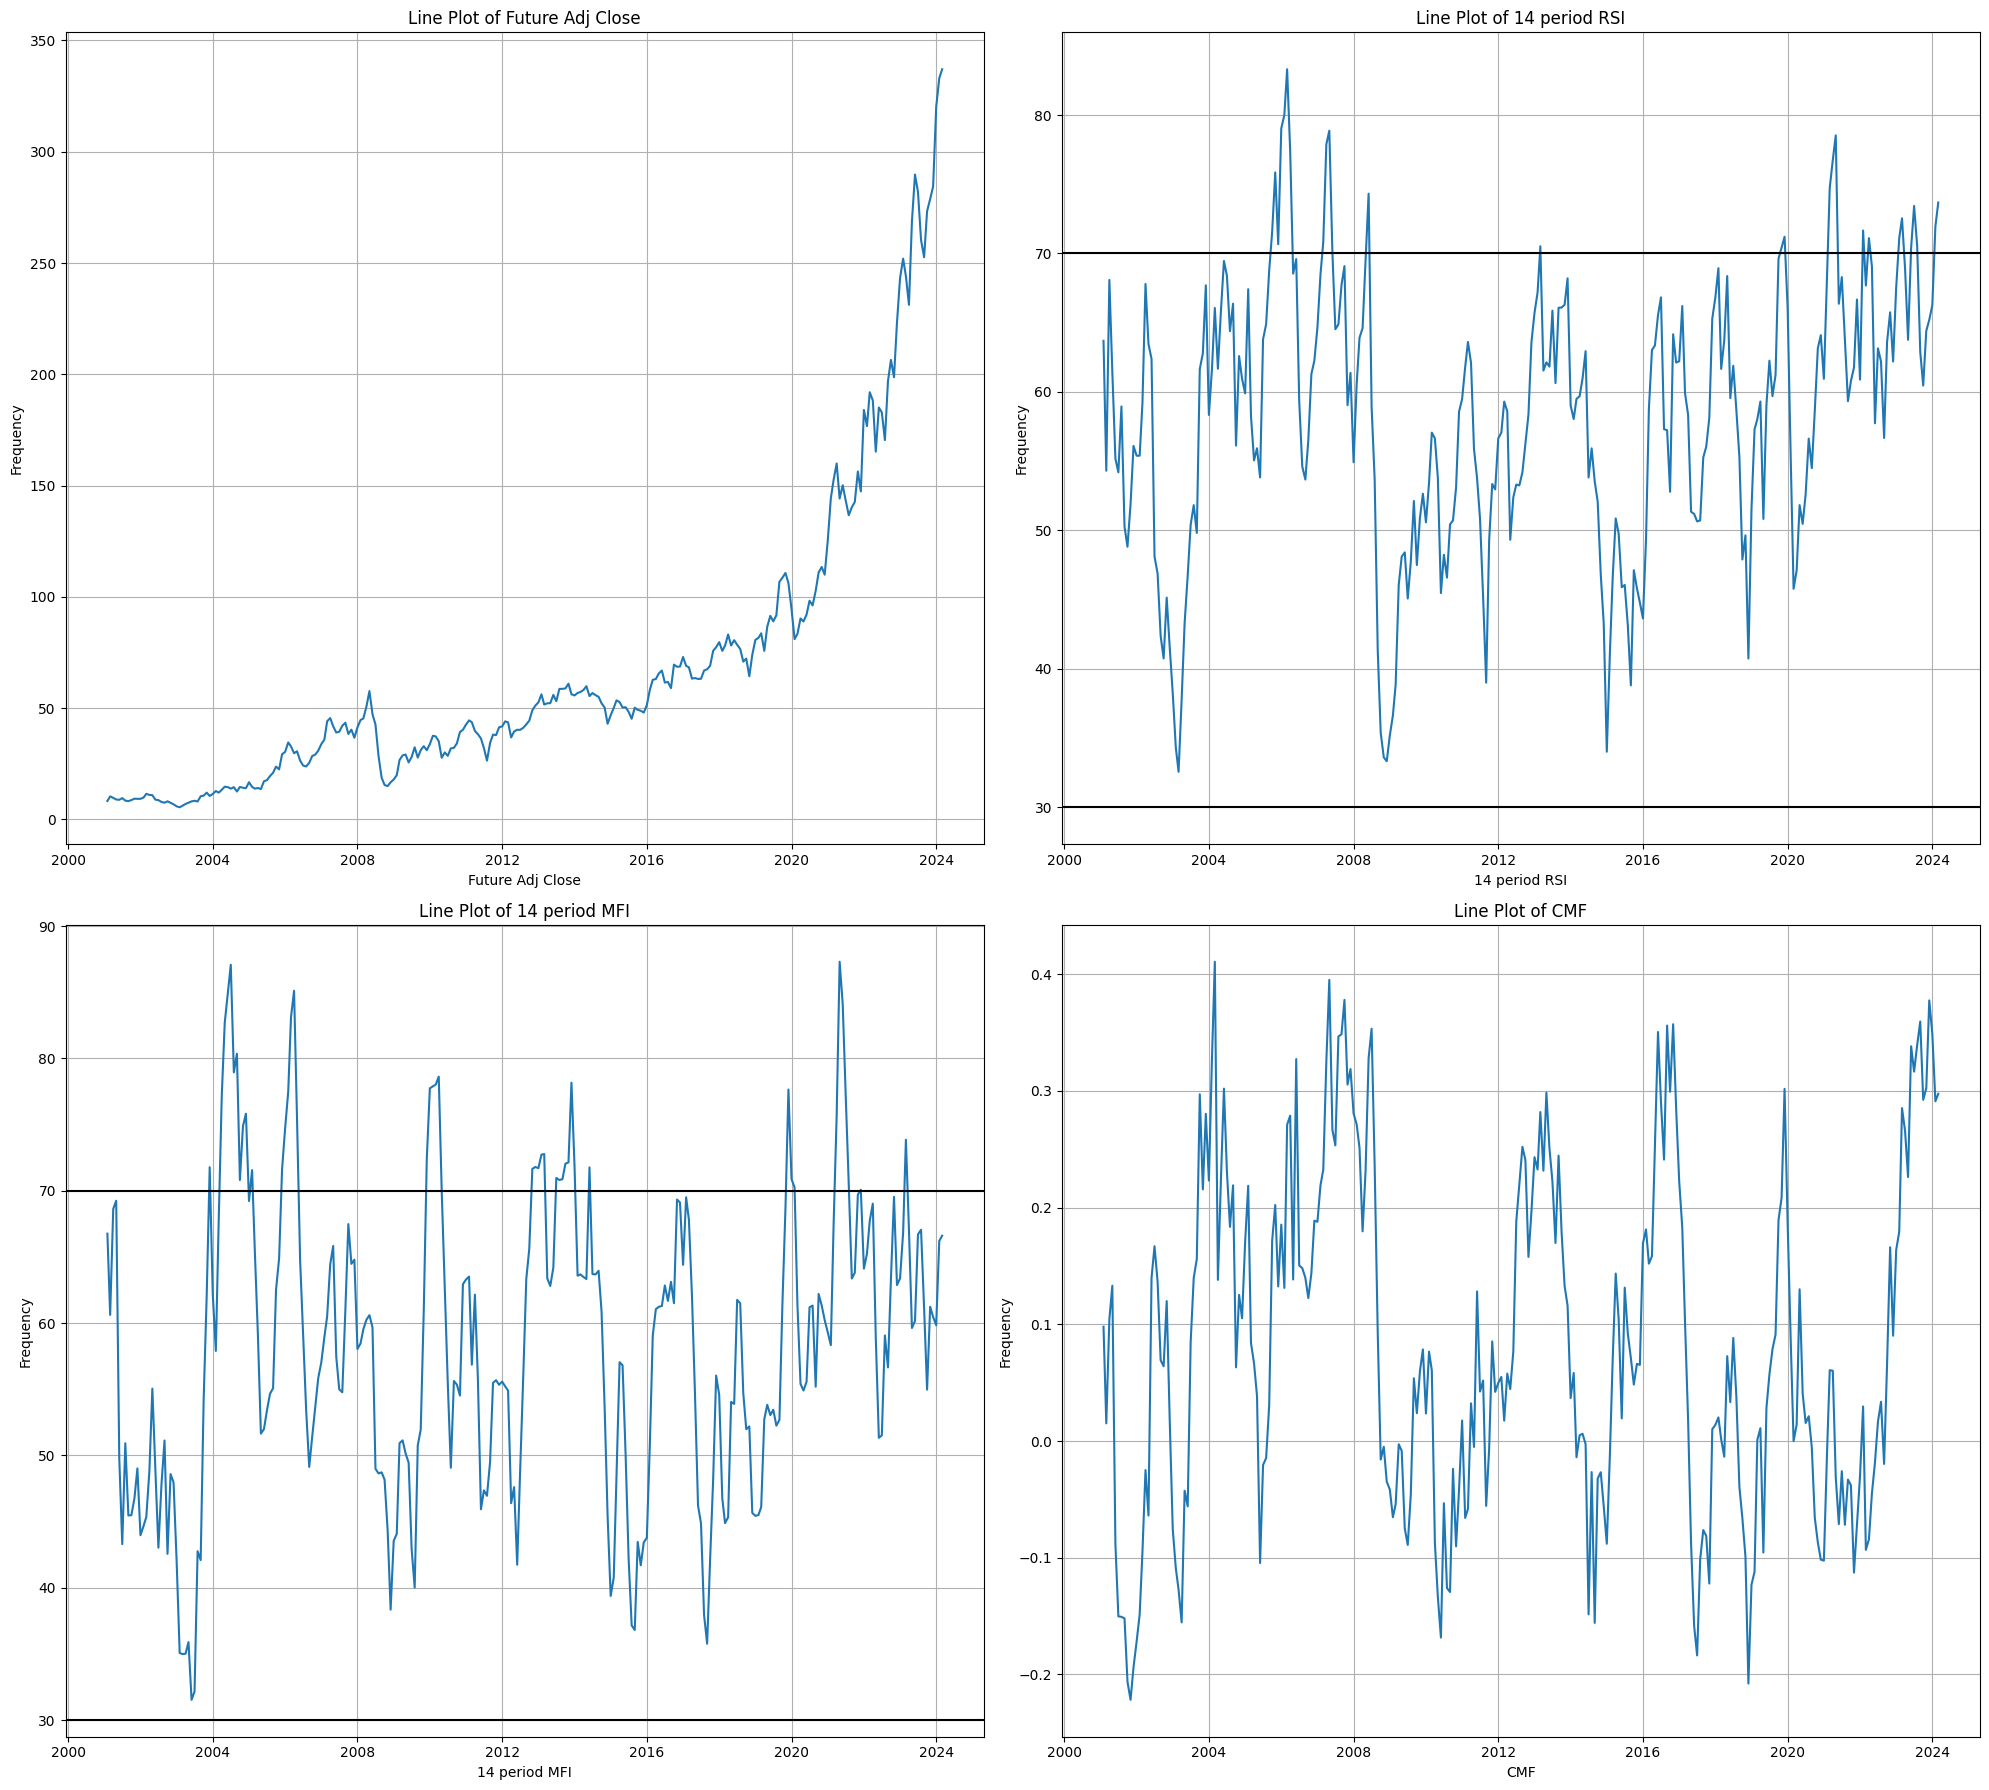

In [63]:
cols = ['Future Adj Close', '14 period RSI','14 period MFI','CMF']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 18))

axes = axes.flatten()

for i, col in enumerate(cols):
    ax=axes[i]
    ax.plot(dataset[col])
    if 0<i<3:
        ax.axhline(30, c='k')
        ax.axhline(70, c='k')
    ax.set_title(f'Line Plot of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.grid(True)
    
plt.tight_layout()

# Show the plot
plt.show()

## Feature Engineering Monthly Data

In [64]:
dataset['Future Adj Close Ret'] = np.log(dataset['Future Adj Close']) - np.log(dataset['Future Adj Close'].shift(periods=-1))
dataset = dataset.drop(columns=['Future Adj Close'],axis=1).dropna()
dataset.head()

,14 period RSI,14 period MFI,CMF,Future Adj Close Ret
Date,,,,
2001-02-01,63.689896,66.755884,0.097972,-0.224958
2001-03-01,54.306865,60.615279,0.015167,0.068871
2001-04-01,68.084537,68.624953,0.104250,0.077825
2001-05-01,61.434825,69.241991,0.133135,0.013959
2001-06-01,55.184002,49.757768,-0.088047,-0.080969


## Cleaning our data further (Visualization)

### Checking for Stationarity

In [65]:
for col in dataset.columns:
    print(col)
    print(check_stationarity(dataset[col].values))

14 period RSI
p-value 5.6899105694352384e-05 The series is likely stationary
True
14 period MFI
p-value 0.004464358321274852 The series is likely stationary
True
CMF
p-value 0.014779205951306546 The series is likely stationary
True
Future Adj Close Ret
p-value 2.505862529195079e-13 The series is likely stationary
True


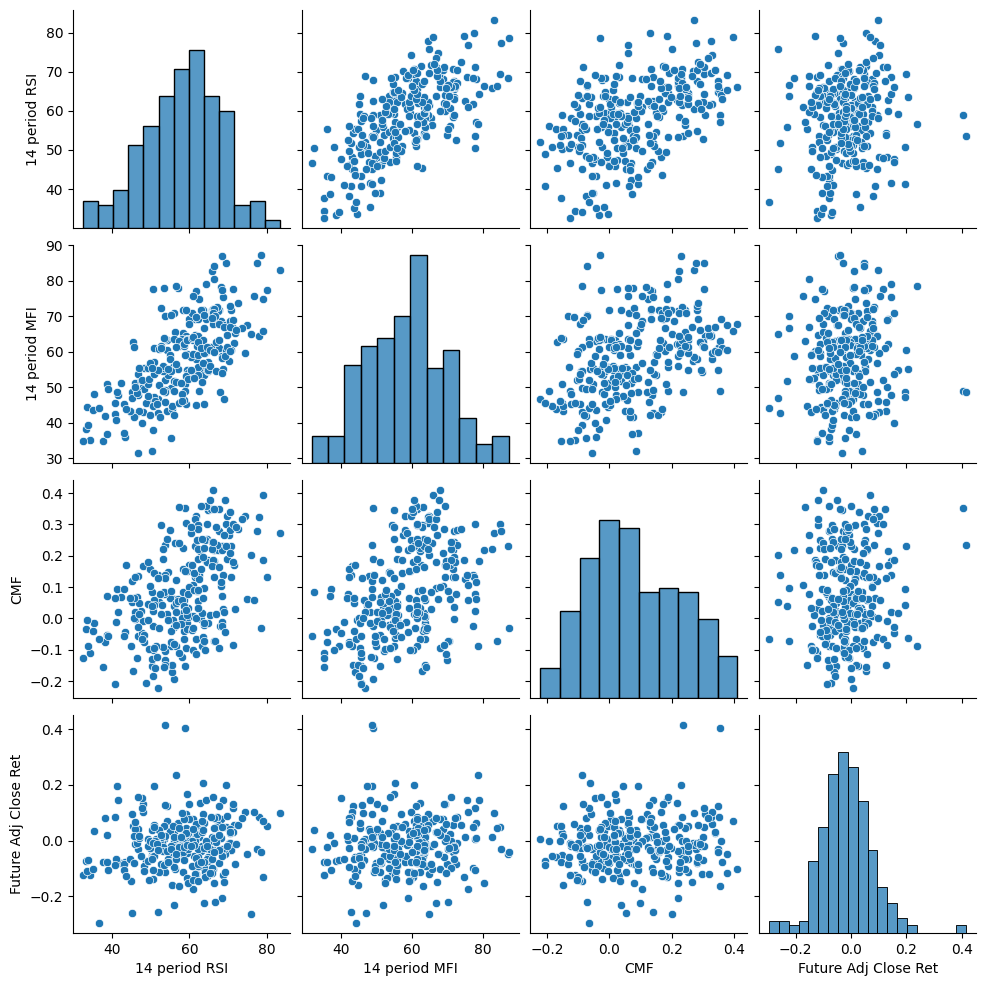

In [66]:
sns.pairplot(dataset)

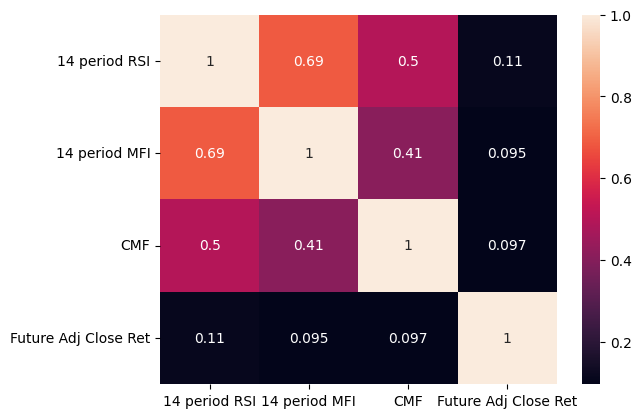

In [67]:
corrmatrix = dataset.corr()
sns.heatmap(corrmatrix, annot=True)
plt.show()

14 Period MFI and CMF are highly correlated so you can drop one of them.

## Check Assumptions

### Splitting data into testing and training sets

In [68]:
from sklearn.model_selection import train_test_split

X = dataset.iloc[:,:3]
y = dataset.iloc[:,-1]

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

### Create the Model

In [70]:
import statsmodels.api as sm

X_train_constant = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_constant).fit()

model.params

const           -0.045166
14 period RSI    0.000325
14 period MFI    0.000211
CMF              0.054665
dtype: float64

In [71]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Future Adj Close Ret   R-squared:                       0.015
Model:                              OLS   Adj. R-squared:                  0.001
Method:                   Least Squares   F-statistic:                     1.067
Date:                  Tue, 09 Apr 2024   Prob (F-statistic):              0.364
Time:                          22:26:11   Log-Likelihood:                 206.36
No. Observations:                   221   AIC:                            -404.7
Df Residuals:                       217   BIC:                            -391.1
Df Model:                             3                                         
Covariance Type:              nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0452      0.045     -1.012      0.313      -0.133       0.043
14 period RSI     0.0003      0.001      0.336      0.737      -0.002       0.002
14 period MFI     0.0002      0.001      0.272      0.786      -0.001       0.002
CMF               0.0547      0.051      1.081      0.281      -0.045       0.154
==============================================================================
Omnibus:                       29.708   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.437
Skew:                           0.606   Prob(JB):                     5.07e-16
Kurtosis:                       5.486   Cond. No.                         743.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
X_test_constant = sm.add_constant(X_test)
y_pred = model.predict(X_test_constant)
residual = y_test - y_pred

In [73]:
model.get_prediction(X_test_constant).summary_frame().head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
Date,,,,,,
2013-05-01,0.004614,0.011622,-0.018291,0.027520,-0.185949,0.195178
2002-05-01,-0.016404,0.012947,-0.041921,0.009113,-0.207299,0.174491
2003-04-01,-0.033984,0.016420,-0.066347,-0.001622,-0.225914,0.157946
2005-11-01,0.004253,0.014737,-0.024792,0.033298,-0.187146,0.195651
2014-02-01,-0.009686,0.007756,-0.024974,0.005601,-0.199485,0.180112


### Homoscedasticity

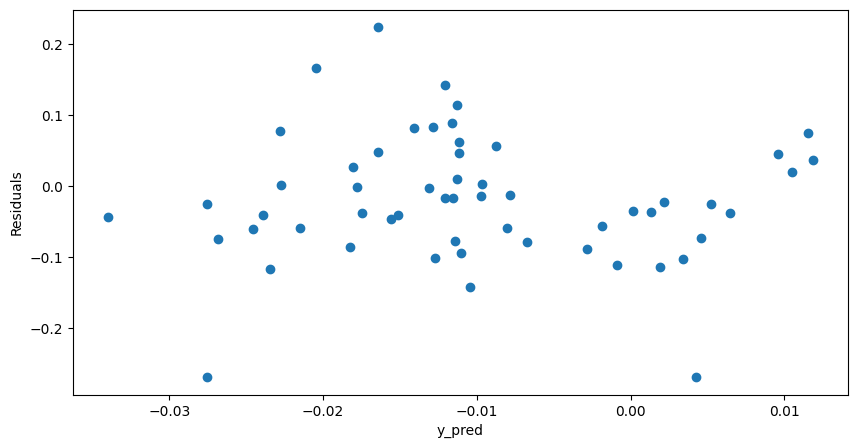

In [74]:
plt.figure(figsize=(10,5))
plt.scatter(y_pred, residual)
plt.xlabel('y_pred')
plt.ylabel('Residuals')
plt.show()

### Multivariate Normality

<Axes: ylabel='Density'>

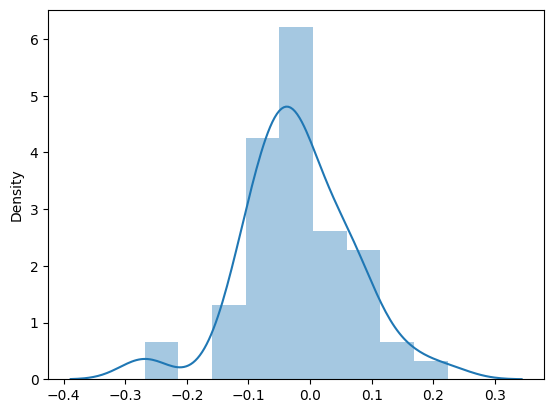

In [75]:
sns.distplot(residual)

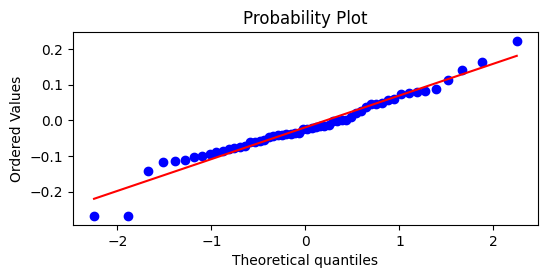

In [76]:
import scipy

fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = scipy.stats.probplot(residual, plot=ax, fit=True)

In [77]:
np.mean(residual)

-0.019451900941765108

### Independece of Observations

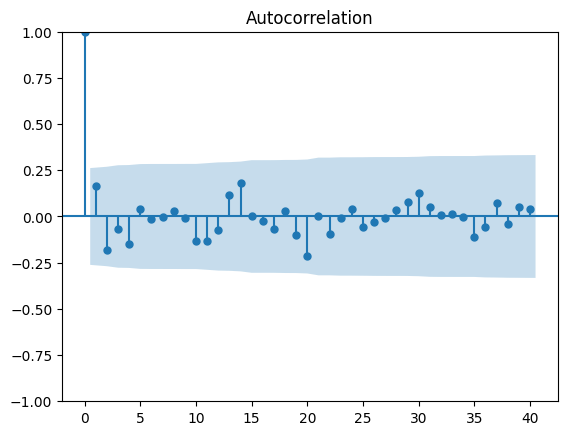

In [78]:
import warnings
import statsmodels.tsa.api as smt

warnings.filterwarnings("ignore")
%matplotlib inline

ALPHA = 0.05
acf = smt.graphics.plot_acf(residual, lags=40 , alpha=ALPHA)
acf.show()

### Lack of Multicollinearity

In [79]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X_train.columns).T

,14 period RSI,14 period MFI,CMF
vif,48.85961,48.451915,1.449436


**NOTE**: We technically do **NOT** know what the true testing data looks like as we will be obtaining these data with time. This analysis to check assumptions should be a **demonstration** of how one would analyze a regression model. Ideally, we would split the data into training, validation, and testing data where we would train the model on training data, then validate our assumptions on the validation data then just test how it would do on unseen data such as the testing data.

# Training the Multiple Linear Regressor

In [80]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

## Making Predictions

In [81]:
y_pred = regressor.predict(X_test)
y_pred

array([ 0.00461446, -0.01640395, -0.03398416,  0.00425284, -0.0096863 ,
        0.01047322, -0.01555749, -0.0131407 , -0.00674066,  0.01153866,
       -0.01116544, -0.00969957, -0.01745734, -0.00183154, -0.00781449,
       -0.01779413,  0.00338927,  0.00191912, -0.01131012, -0.01155636,
       -0.02153346, -0.02752212, -0.01209762, -0.01802385, -0.00874273,
       -0.02043858,  0.00017342, -0.00802816, -0.01274099,  0.01184898,
        0.009604  , -0.01285198, -0.0227833 , -0.0008729 , -0.0182476 ,
       -0.01102549, -0.02276122, -0.01116157, -0.0120799 , -0.01163559,
       -0.01644068, -0.0113165 , -0.0028137 ,  0.00136296,  0.0022077 ,
       -0.02342436, -0.02387762, -0.02680701,  0.00522883,  0.00644277,
       -0.01042258, -0.01510572, -0.01408687, -0.02456118, -0.01139999,
       -0.02753144])

## Prediction Metrics

In [82]:
from sklearn.metrics import mean_squared_error

print("Intercept: %.6f" % regressor.intercept_)
print("Coefficient: %s" % regressor.coef_)
print("R^2: %.6f" % regressor.score(X_test, y_test))
print("RMSE %.6f" % np.sqrt(mean_squared_error(y_test, y_pred)))

Intercept: -0.045166
Coefficient: [0.0003253  0.0002109  0.05466511]
R^2: -0.039190
RMSE 0.090571


## Predictions vs Actual

In [83]:
df = pd.DataFrame(data=np.concatenate((y_pred.reshape(len(y_pred),1), pd.DataFrame(y_test).values.reshape(len(pd.DataFrame(y_test).values),1)),1), columns=['Predicted Returns', 'Actual Returns'])
df.head()

,Predicted Returns,Actual Returns
0,0.004614,-0.068383
1,-0.016404,0.206883
2,-0.033984,-0.078045
3,0.004253,-0.264429
4,-0.009686,-0.007382


## Visualizing Training Data

In [84]:
training_dates, testing_dates = X_train.index, X_test.index

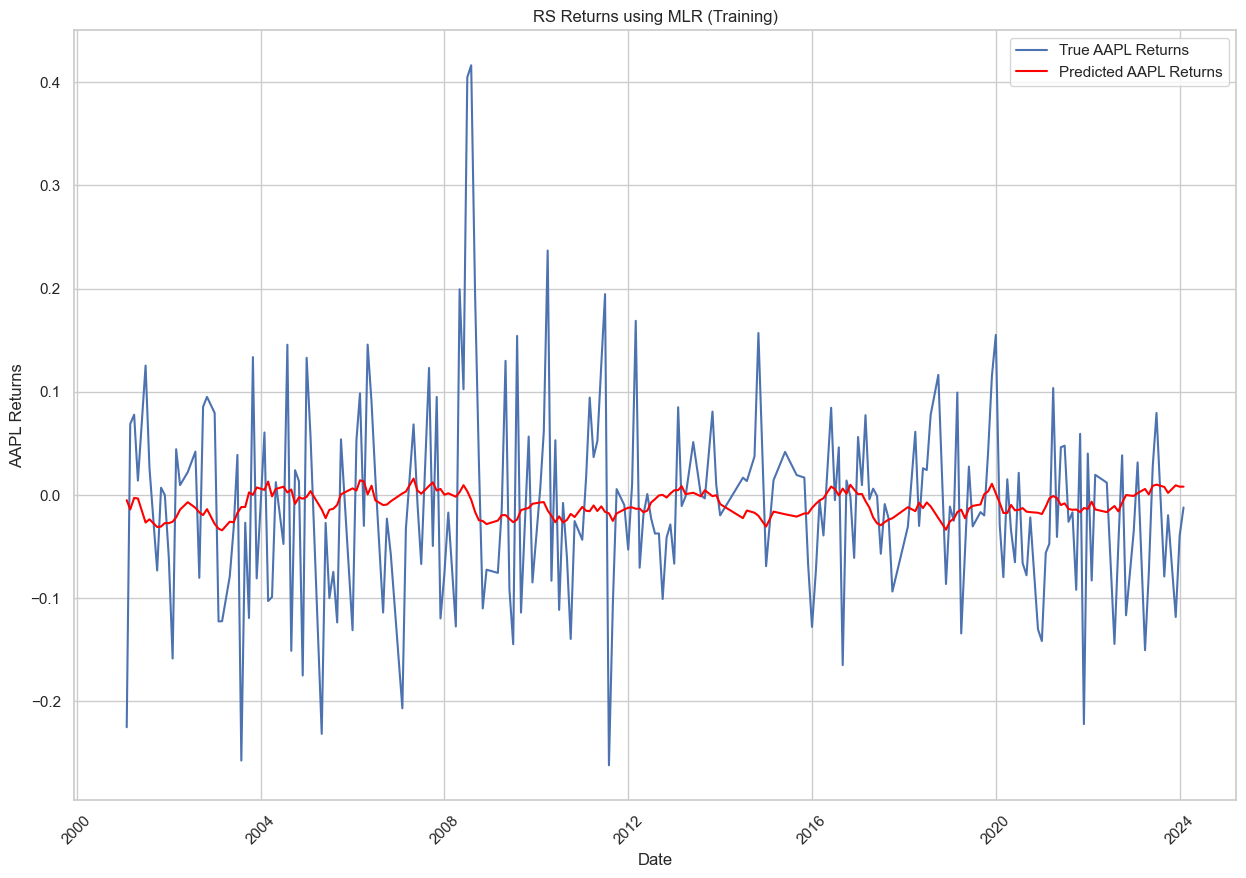

In [95]:
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(15, 10))

# Plot the true AAPL Returns
sns.lineplot(x=training_dates, y=y_train, label='True AAPL Returns')

# Plot the predicted AAPL Returns
sns.lineplot(x=training_dates, y=regressor.predict(X_train), color='red', label='Predicted AAPL Returns')

# Set the title and labels
plt.title("RS Returns using MLR (Training)")
plt.xlabel("Date")
plt.ylabel("AAPL Returns")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.legend()
plt.show()

## Visualizing Testing Data

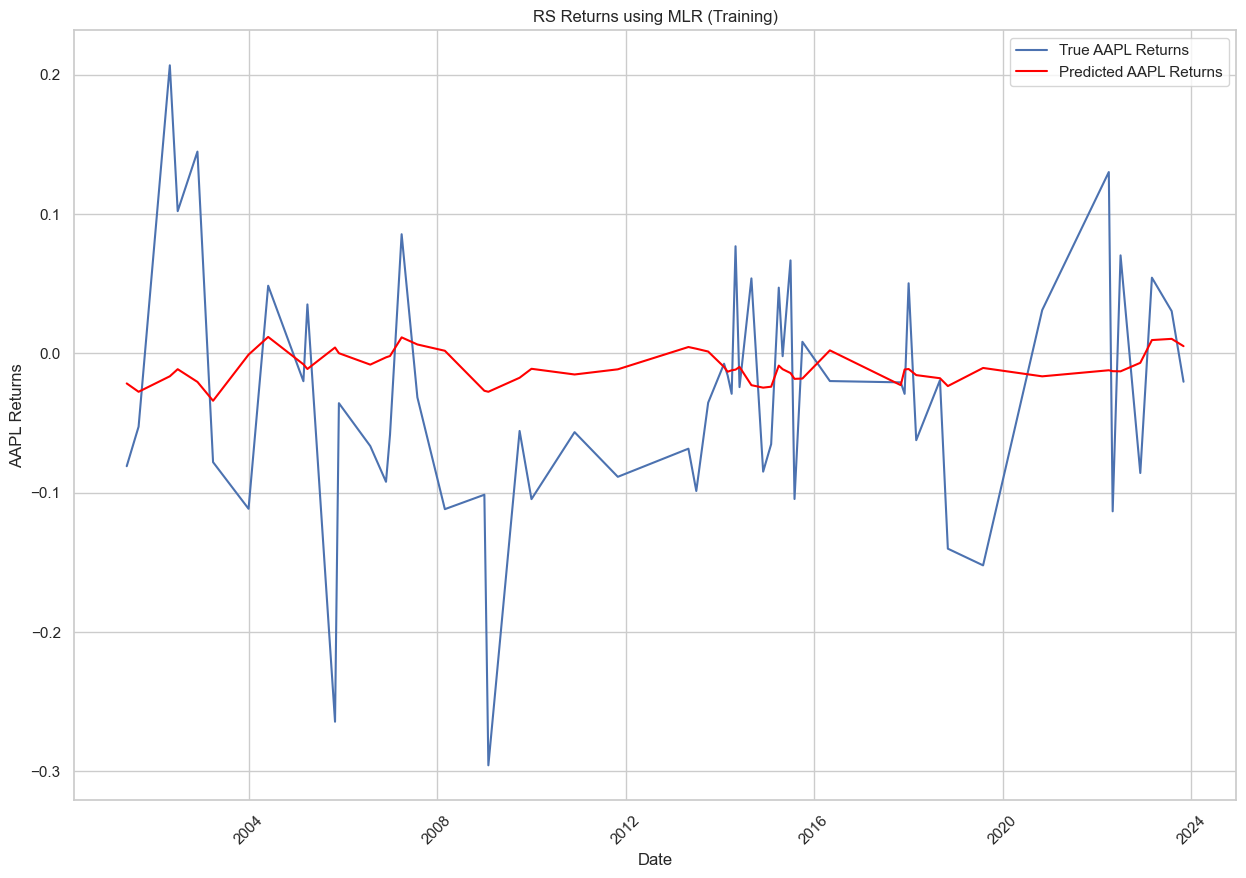

In [98]:
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(15, 10))

# Plot the true AAPL Returns
sns.lineplot(x=testing_dates, y=y_test, label='True AAPL Returns')

# Plot the predicted AAPL Returns
sns.lineplot(x=testing_dates, y=regressor.predict(X_test), color='red', label='Predicted AAPL Returns')

# Set the title and labels
plt.title("RS Returns using MLR (Training)")
plt.xlabel("Date")
plt.ylabel("AAPL Returns")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.legend()
plt.show()

NOTE: Regression models tend to behave poorly with outliers. How can we optimize this model further?

# Deep Learning Model (LSTM)

In [99]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

## Standardize the data

In [100]:
# In case you run into issues and do not want to scroll back up
TRAIN_SIZE = 0.80
X_train, X_test, y_train, y_test = X[:round(X.shape[0]*(TRAIN_SIZE))], X[round(X.shape[0]*(TRAIN_SIZE)):], y[:round(y.shape[0]*(TRAIN_SIZE))], y[round(y.shape[0]*(TRAIN_SIZE)):]


In [101]:
# data must be at least 2D for std scalar
print(y_train.shape)
y_train = y_train.values.reshape((-1, 1))
y_test = y_test.values.reshape((-1, 1))

print(y_train.shape)

(222,)
(222, 1)


In [102]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

sc_y = StandardScaler()
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

### Reshape Features for LSTM Input Layer

In [103]:
print("BEFORE:")
print(X_train.shape)
print(X_test.shape)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("AFTER:")
print(X_train.shape)
print(X_test.shape)

BEFORE:
(222, 3)
(55, 3)
AFTER:
(222, 3, 1)
(55, 3, 1)


In [104]:
# Creating the Network
model = Sequential()
# Input Layer
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
# add Dropout Layer
model.add(Dropout(0.4))
# First Hidden Layer
model.add(LSTM(units=32, return_sequences=True))
# add Dropout Layer
model.add(Dropout(0.4))
# Second Hidden Layer
model.add(LSTM(units=32, return_sequences=False))
# add Dropout Layer
model.add(Dropout(0.4))
# Output Layer
model.add(Dense(units=1))

# Compile LSTM
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_percentage_error', 'mean_absolute_error'])

# print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 3, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 3, 32)               │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,025 (82.13 KB)

 Trainable params: 21,025 (82.13 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
!pip install pydot
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [107]:
model.fit(X_train, y_train, batch_size = 32, epochs = 50)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 1.1194 - mean_absolute_error: 0.7539 - mean_absolute_percentage_error: 100.0843
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8446 - mean_absolute_error: 0.7059 - mean_absolute_percentage_error: 102.9848
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0716 - mean_absolute_error: 0.7582 - mean_absolute_percentage_error: 109.4716  
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0166 - mean_absolute_error: 0.7321 - mean_absolute_percentage_error: 112.3051 
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1564 - mean_absolute_error: 0.7781 - mean_absolute_percentage_error: 105.5754
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9761 - mean_absolute_error: 0.7450 - mean_absolute_percentage_error: 110.7303 
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0886 - mean_absolute_error: 0.7540 - mean_absolute_percentage_error: 160.0518 
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5m

### Visualize Training Data

In [108]:
y_pred_train = model.predict(X_train)
y_pred_train = sc_y.inverse_transform(y_pred_train)

y_pred_test = model.predict(X_test)
y_pred_test = sc_y.inverse_transform(y_pred_test)

y_train = sc_y.inverse_transform(y_train)
y_test = sc_y.inverse_transform(y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [119]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred_test[:-1], y_test[:-1])
print(f"MSE = {round(mse, 6)}")
print(f"RMSE = {round(np.sqrt(mse), 6)}")

MSE = 0.006527
RMSE = 0.08079


In [133]:
y_test.shape

(55, 1)

In [131]:
training_dates = pd.Series(training_dates)
y_train = pd.Series(y_train)

# Set the style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(15, 10))

# Plot the true AAPL Returns
sns.lineplot(x=training_dates, y=y_train, label='True AAPL Returns')

# Plot the predicted AAPL Returns
sns.lineplot(x=training_dates, y=regressor.predict(X_train), color='red', label='Predicted AAPL Returns')

# Set the title and labels
plt.title("RS Returns using MLR (Training)")
plt.xlabel("Date")
plt.ylabel("AAPL Returns")

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.legend()
plt.show()

ValueError: Data must be 1-dimensional, got ndarray of shape (222, 1) instead